# Chapter 9: Dimensionality reduction

In [1]:
%reset
%matplotlib inline
low_memory=False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns; sns.set()
from scipy import stats
import math
import os
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 9.1 Introduction & Motivation

We've seen quite a few regression, classification and clustering methods. That's great! We can already train a lot of different models and gain insights from them. However, now it's time to take a small step back and look at the data we are feeding our models. Instead of just throwing everything we have at it, we are going to reduce our data by performing **PCA**.

Why do we do this? When working with large dataset, training a model becomes more complex. For example, think of the training process of a GPT model. The more data is being used, the more time it will take to train and the more CPU power it will use, requiring expensive machinery and also driving up the electricity bill like crazy. We do however want to retain most of the information contained in our data. That's where PCA comes into play. We reduce data by reshaping it to a few core components and keeping the information contained within.

## 9.2 Problem Setting

Consider an automobile manufacturer that has created prototypes for a new vehicle. Prior to launching this new model, the manufacturer aims to identify which current vehicles on the market closely resemble the prototypes. This involves categorizing vehicles, determining which category is most similar to the new model, and identifying the models it will compete against.

The goal is to employ clustering techniques to identify the most distinct groups of vehicles. This will provide an overview of the current market and assist manufacturers in making informed decisions regarding the introduction of new models.

## 8.3 Model

First, let's have a look at the data.

In [2]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


##### Question 1: By now you should be familiar with the digits dataset. Visualize the faces dataset in a similar way. Show only the first 5 faces. Can you display the correct name as labels?

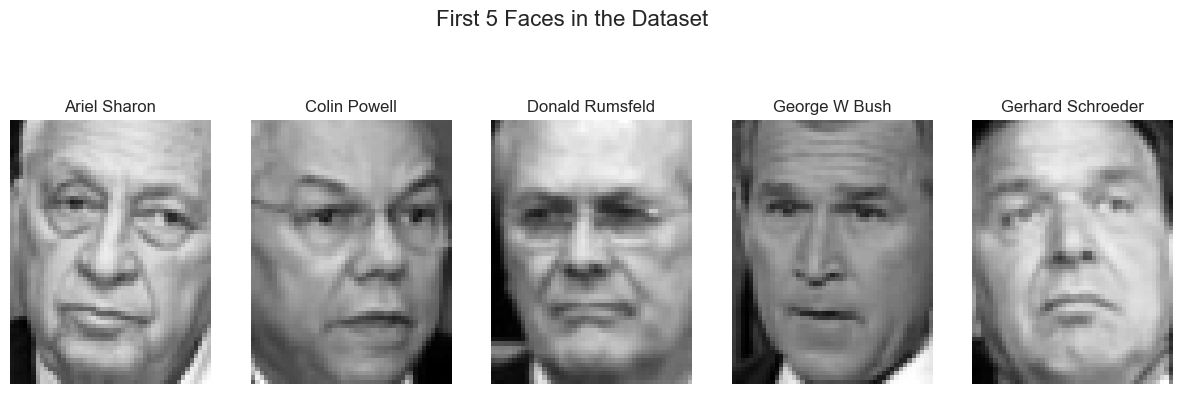

In [3]:

images =faces.images
names= faces.target_names
labels = faces.target
unique_indices=np.unique(labels,return_index=True)[1]
fig,axes=plt.subplots(1,5,figsize=(15,5))
for i,ax in enumerate(axes):
    ax.imshow(images[unique_indices[i]],cmap='gray')
    ax.set_title(names[labels[unique_indices[i]]])
    ax.axis('off')
plt.suptitle("First 5 Faces in the Dataset",fontsize=16)
plt.show()

##### Question 2: Train a classification method of your choice to get some predictions. Use cross-validation to get the best results. Remember to select the best parameters!

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
X = faces.data 
y = faces.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight='balanced'))
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}
grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print(f"Best cross-validation score: { grid.best_score_:.2f}")

y_pred=grid.predict(X_test)
print("\nClassification Report:\n",classification_report(y_test,y_pred,target_names=faces.target_names))

## 9.4 Model Evaluation

##### Question 3: It's time to reduce our data using PCA! figure out the best amount of principal components and reduce the data.

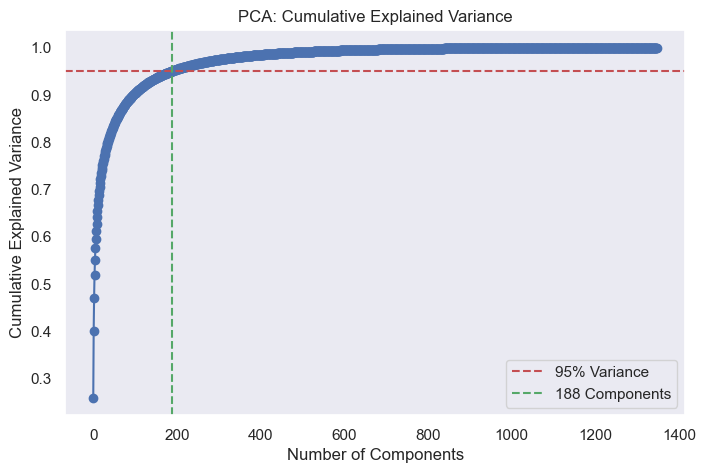

Optimal number of components: 188
Reduced dataset shape:(1348, 188)


In [5]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_scaled=scaler.fit_transform(X)
pca=PCA()
X_pca=pca.fit_transform(x_scaled)
cumulative_variance=np.cumsum(pca.explained_variance_ratio_)
n_components=np.argmax(cumulative_variance>=0.95)+1

plt.figure(figsize=(8,5))
plt.plot(cumulative_variance,marker='o')
plt.axhline(y=0.95,color='r',linestyle='--',label="95% Variance")
plt.axvline(x=n_components,color='g',linestyle='--',label=f"{n_components} Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()
pca_optimal=PCA(n_components=n_components)
X_reduced=pca_optimal.fit_transform(x_scaled)
print(f"Optimal number of components: {n_components}")
print(f"Reduced dataset shape:{X_reduced.shape}")


##### Question 4: Do you notice something special about the eigenvalues? What is the total sum of all eigenvalues? Play around with models with different amount of components. How does this change? Is this expected? Elaborate based on the meaning of eigenvalue.

In [6]:
total_variance=np.sum(pca.explained_variance_)
print(f"Total Sum of Eigenvalues (Variance): {total_variance}")


Total Sum of Eigenvalues (Variance): 2916.162353515625


##### Question 5: Use PCA and the best amount of components you found earlier to reduce your data. Retrain your model using kfold and compare the accuracy. What do you notice?

In [7]:
pca_optimal =PCA(n_components=n_components)
X_pca = pca_optimal.fit_transform(x_scaled)
pipeline_pca = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight='balanced'))
cv_scores_pca=cross_val_score(pipeline_pca,X_pca,y,cv=5)
pipeline_full = make_pipeline(StandardScaler(), SVC(kernel='rbf', class_weight='balanced'))
cv_scores_full=cross_val_score(pipeline_full,x_scaled,y,cv=5)
print("Accuracy with PCA-reduced data (K-fold):",np.mean(cv_scores_pca))
print("Accuracy with full data (K-fold):",np.mean(cv_scores_full))


Accuracy with PCA-reduced data (K-fold): 0.7863775299463032
Accuracy with full data (K-fold): 0.7856312818394603


##### Question 6: Your department just got granted some extra budget. You are able to use some more processing power, but still not enough to use the entire dataset. Your boss wants you to create a model that contains 90% of all variance. Create this model and calculate the accuracy as before. By how much did you reduce the size of your dataset?

In [8]:
pca=PCA()
pca.fit(x_scaled)

cumulative_variance=np.cumsum(pca.explained_variance_ratio_)
n_components_90=np.argmax(cumulative_variance>=0.90)+1

pca_90=PCA(n_components=n_components)
x_pca_90=pca_90.fit_transform(x_scaled)

pipeline_pca_90=make_pipeline(StandardScaler(),SVC(kernel='rbf',class_weight='balanced'))
cv_scores_90=cross_val_score(pipeline_pca_90,x_pca_90,y,cv=5)
accuracy_pca_90=np.mean(cv_scores_90)

original_features=x_scaled.shape[1]
reduced_features=x_pca_90.shape[1]
size_reduction_percentage=(1-reduced_features/original_features)*100

print(f"Accuracy with 90% variance retained: {accuracy_pca_90:.4f}")
print(f"Original number of features: {original_features}")
print(f"Reduced number of features: {reduced_features}")
print(f"Dataset size reduction: {size_reduction_percentage:.2f}%")

Accuracy with 90% variance retained: 0.7864
Original number of features: 2914
Reduced number of features: 188
Dataset size reduction: 93.55%


## 9.5 Exercises

##### Question 1: See section 9.3
##### Question 2: See section 9.3
##### Question 3: See section 9.4
##### Question 4: See section 9.4
##### Question 5: See section 9.4
##### Question 6: See section 9.4
##### Question 7: PCA is used to reduce the amount of variables by creating new variables which explain multiple previous ones. By definition, you should get somewhat usable results when reversing this process. Transform your prejected data from question 6 back into the original amount of dimensions and compare the data by looking at the the datapoints of the first face.

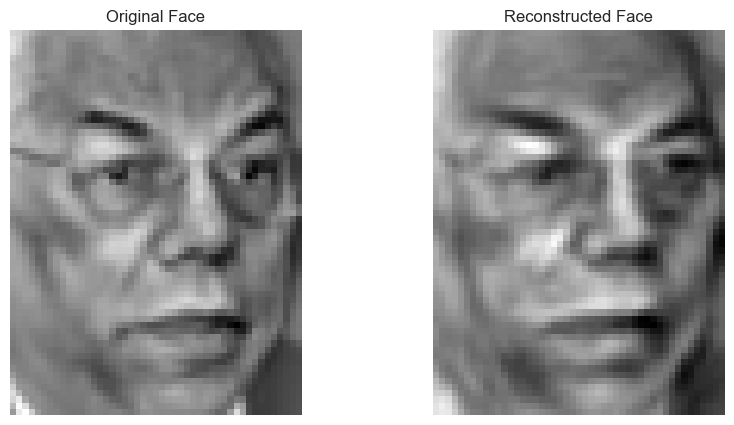

In [9]:
X_reconstracted=pca_90.inverse_transform(x_pca_90)
original_first_face=x_scaled[0]
reconstructed_first_face=X_reconstracted[0]
image_height, image_width = 62, 47 #2914
# Original face
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_first_face.reshape((image_height,image_width)),cmap='gray')
plt.title("Original Face")
plt.axis('off')
# Reconstrected Face
plt.subplot(1,2,2)
plt.imshow(reconstructed_first_face.reshape((image_height,image_width)),cmap='gray')
plt.title("Reconstructed Face")
plt.axis('off')
plt.show()

In [10]:
print(f"Shape of original data: {x_scaled[0].shape}")

Shape of original data: (2914,)


##### Question 8: Now that you have figured out the process of reversing PCA, visualize the reversed data. Compare the reconstructed faces with the original ones and behold the true power of PCA!

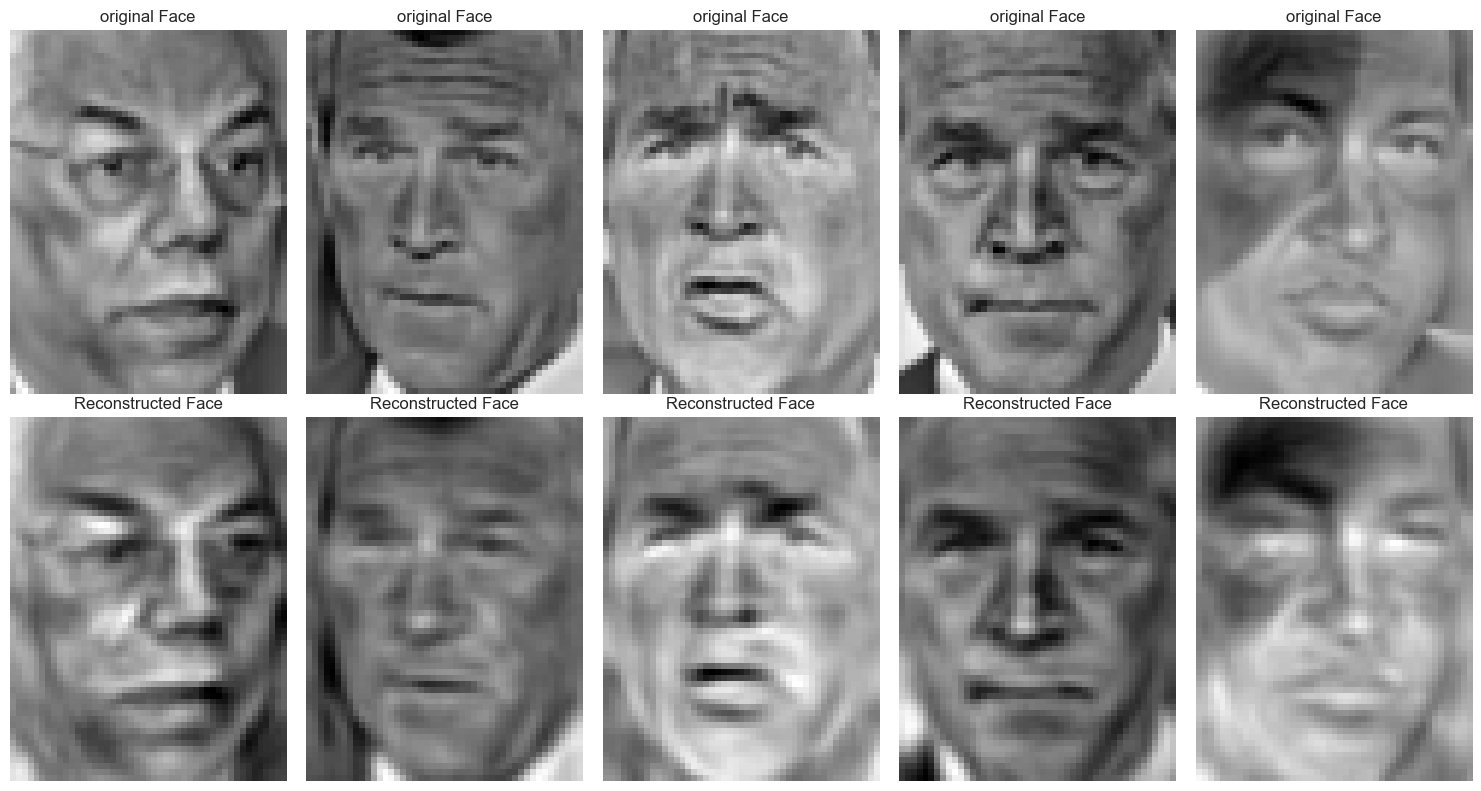

In [18]:
image_height,image_width=62,47
num_faces=5
original_faces=x_scaled[:num_faces]
reconstructed_faces=X_reconstracted[:num_faces]
plt.figure(figsize=(15,8))
for i in range(num_faces):
    plt.subplot(2,num_faces,i+1)
    plt.imshow(original_faces[i].reshape((image_height,image_width)),cmap='gray')
    plt.title("original Face")
    plt.axis('off')
    plt.subplot(2, num_faces, num_faces + i + 1)
    plt.imshow(reconstructed_faces[i].reshape((image_height,image_width)),cmap='gray')
    plt.title("Reconstructed Face")
    plt.axis('off')
    
plt.tight_layout()
plt.show()

##### Question 9: We talked briefly about how PCA can be used to reduce noise. Assume the 'noisy' data as seen below. Plot the faces as you did before to visually see the noise. What's the best result you can achieve when using PCA to reduce the noise?

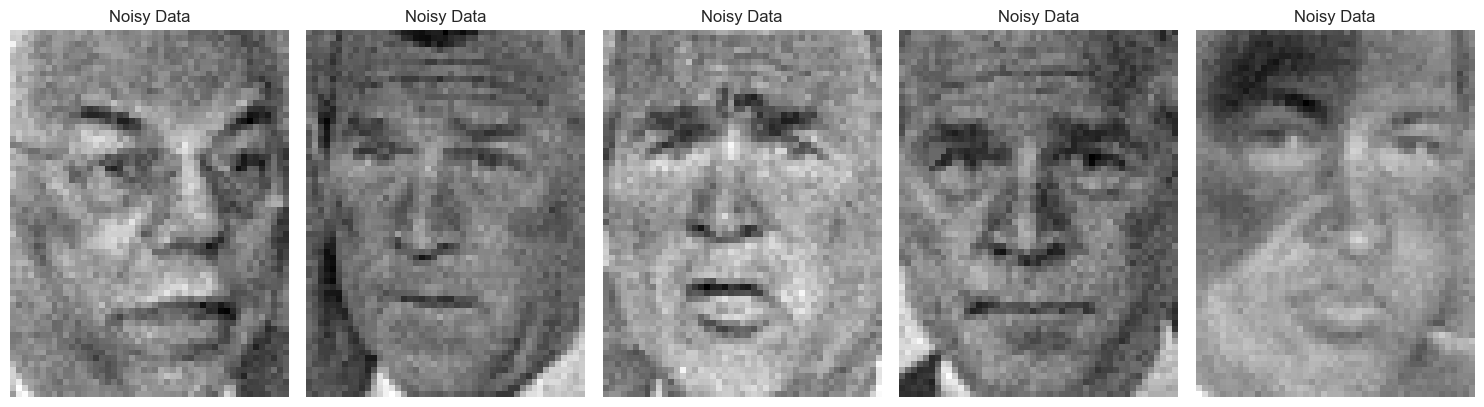

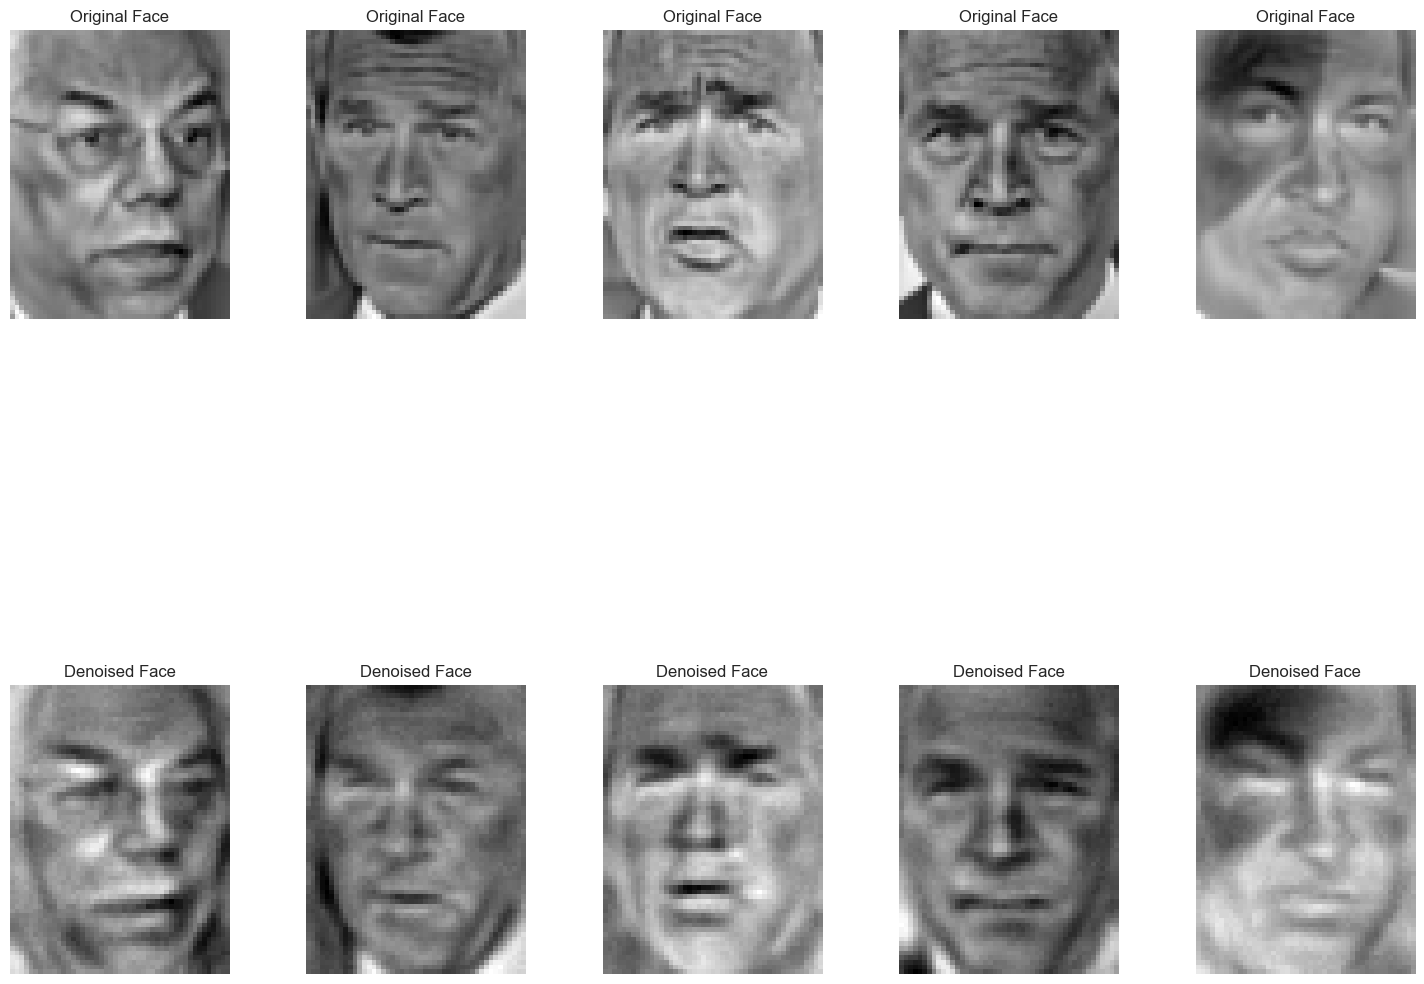

In [20]:
noise_factor=0.2
noisy_data=x_scaled+noise_factor *np.random.normal(loc=0.0,scale=1.0,size=x_scaled.shape)
noisy_dat=np.clip(noisy_data,0.0,1.0)
num_faces=5
plt.figure(figsize=(15,5))
for i in range(num_faces):
    plt.subplot(1,num_faces,i+1)
    plt.imshow(noisy_data[i].reshape((image_height,image_width)),cmap='gray')
    plt.title("Noisy Data")
    plt.axis('off')
plt.tight_layout()
plt.show()

pca=PCA(n_components=0.9)
noisy_data_pca=pca.fit_transform(noisy_data)
reconstructed_data=pca.inverse_transform(noisy_data_pca)
plt.figure(figsize=(15,10))
for i in range(num_faces):
    plt.subplot(3,num_faces,i +1)
    plt.imshow(x_scaled[i].reshape((image_height,image_width)),cmap='gray')
    plt.title("Original Face")
    plt.axis('off')
    plt.subplot(3, num_faces, 2 * num_faces + i + 1)
    plt.imshow(reconstructed_data[i].reshape((image_height, image_width)), cmap='gray')
    plt.title("Denoised Face")
    plt.axis('off')

plt.tight_layout()
plt.show()